<a href="https://colab.research.google.com/github/mong-head/machine_learning/blob/master/mideterm_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# drive 저장 및 set up

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

from pandas import Series, DataFrame

# * data 처리

Load TADPOLE* dataset (csv file) from Google Drive
-------------------------------------------------------
*The Alzheimer's Disease Prediction Of Longitudinal Evolution
(https://tadpole.grand-challenge.org/)

### -Subjects: 1707 (1363 Train (80%) + 344 Test (20%))
### -Features: 72
*   2 demographic feature: MMSE, ADAS13
*   70 mean values of cortical thickness

데이터 불러오기

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

csv_file_train = '/content/gdrive/My Drive/BNCS401_Midterm_Project/Train_data_reupdated.csv'  # Set your path
train_data = pd.read_csv(csv_file_train)
train_data

# DXCHANGE: clinical label (1-CN, 2-MCI, 3-AD)

Mounted at /content/gdrive


,RID,DXCHANGE,AGE,MMSE,ADAS13,ST102TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST103TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST104TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST105TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST106TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST107TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST108TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST109TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST110TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST111TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST113TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST114TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST115TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST116TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST117TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST118TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST119TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST121TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST123TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST129TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST130TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST13TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST14TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST15TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST23TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST24TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST25TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST26TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST31TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST32TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST34TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST35TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST36TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST38TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST39TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST40TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST43TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST44TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST45TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST46TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST47TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST48TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST49TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST50TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST51TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST52TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST54TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST55TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST56TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST57TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST58TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST59TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST60TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST62TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST64TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST72TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST73TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST74TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST82TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST83TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST84TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST85TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST90TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST91TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST93TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST94TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST95TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST97TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16
0,4084,1,68.4,30,10.00,2.700,2.635,2.613,2.904,2.311,1.647,2.139,2.652,2.604,2.480,3.095,2.144,2.792,2.207,2.903,2.617,4.117,2.701,,3.127,3.051,2.305,2.872,2.732,2.026,3.756,2.813,2.762,2.556,2.916,2.695,2.259,2.690,2.017,2.421,2.949,2.570,2.370,2.674,3.004,2.369,1.599,2.208,2.650,2.739,2.544,3.018,2.377,2.880,2.322,2.657,2.489,3.620,2.711,,2.593,2.792,2.660,1.993,3.734,2.390,2.817,2.471,2.990,2.667,2.490,2.523,2.254,2.171,2.862
1,2196,2,68.2,30,13.00,2.453,2.992,2.470,2.965,2.438,1.584,1.910,2.900,2.451,2.335,2.771,2.354,2.712,2.001,2.729,2.363,3.613,2.475,,3.196,3.334,2.343,2.729,2.627,1.742,3.383,2.647,2.758,2.394,2.634,2.334,2.241,2.824,1.865,2.383,2.866,2.334,2.793,2.413,2.874,2.316,1.478,1.909,2.780,2.589,2.133,3.036,2.329,2.687,2.070,2.783,2.594,3.405,2.367,,2.582,2.977,2.489,1.868,3.220,2.683,2.569,2.372,2.854,2.867,2.233,2.793,1.987,2.428,2.943
2,657,1,77.7,29,15.33,2.249,2.296,2.315,2.681,2.420,1.386,1.830,2.466,2.3

train_data.info()로 확인하니, 빠져있는 데이터도 있고(예측값인 ADAS13, cortical값 중에 1개), 실제로는 NaN값이지만 ' '로 채워진 데이터가 2개가 있었다.

' '로 채워져 있어 object인 두 cortical값
*   ST64TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16
*   ST123TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16

데이터 처리 순서
1. object 처리 : space to NaN
2. imputer : median으로 빠져있는 값들 채우기
3. feature scaling - RobustScaler : cortical, age 값의 범위를 같게 맞춘다.

** StandardScaler안쓰고 RobustScaler하는 이유 : 실제로 이게 더 나았음- outlier제거가 되기때문임

2,3을 pipeline으로 하고, 2 전에 AD_tr(cortical값들, age),y(reg/cls)로 나누고,

AD_tr만 pipeline해서 X로 만들고, y는 imputer만 한다.


1) object처리
---

In [0]:
#2개의 cortical feature가 float이 아니라 object이고, ' '로 채워져있다.
ob1 = train_data["ST64TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16"]
ob2 = train_data["ST123TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16"]
print(len(train_data[ob1.isnull()]), ob1.dtypes)
print(len(train_data[ob2.isnull()]),ob2.dtypes)

0 object
0 object


In [0]:
#그냥 ' '로 뜬다.
train_data["ST64TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16"][0]

' '

In [0]:
def object_to_float(o): #o = train_data["~~"] 형태
  for i in range(1363):
    if o[i] == ' ':
      o[i] = np.nan #nan으로 채움

In [0]:
object_to_float(ob1)
object_to_float(ob2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
print(len(train_data[ob1.isnull()]), ob1.dtypes)
print(len(train_data[ob2.isnull()]),ob2.dtypes)

724 object
724 object


**train, test set나누기
---
AD_train, AD_test = 

In [0]:
#RID는 버림
train_data = train_data.drop("RID",axis=1)

** trian, test set 나누기
---
train set에서 model들의 train loss와 validation loss등을 보며 model을 결정하고

test set에서 마지막으로 검사해보았을 때에도 최적의 모델이라면 

그 모델을 선택하고, 마지막에는 train, test set 나누기 전의 X로 최종으로 선택했던 모델로 마지막 training시킨다.

In [0]:
from sklearn.model_selection import train_test_split

AD_train, AD_test = train_test_split(train_data,test_size=0.2,random_state= 42)

** AD_tr, y나누고, y에는 imputer
---

RID는 버린다.

In [0]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [0]:
##input 해당
X_prepipeline = train_data.drop("MMSE",axis = 1).drop("ADAS13",axis = 1).drop("DXCHANGE",axis = 1)
X_train_prepipeline = AD_train.drop("MMSE",axis = 1).drop("ADAS13",axis = 1).drop("DXCHANGE",axis = 1)
X_test_prepipeline = AD_test.drop("MMSE",axis = 1).drop("ADAS13",axis = 1).drop("DXCHANGE",axis = 1)

#classification input
X_plus_prepipeline = train_data.drop("DXCHANGE",axis = 1)
X_plus_train_prepipeline = AD_train.drop("DXCHANGE",axis = 1)
X_plus_test_prepipeline = AD_test.drop("DXCHANGE",axis = 1)

##output 해당
AD_label_reg = DataFrame({"MMSE":train_data["MMSE"].copy(),
                         "ADAS13":train_data["ADAS13"].copy()})
AD_label_reg_tr = DataFrame({"MMSE":AD_train["MMSE"].copy(),
                         "ADAS13":AD_train["ADAS13"].copy()})
AD_label_reg_test = DataFrame({"MMSE":AD_test["MMSE"].copy(),
                         "ADAS13":AD_test["ADAS13"].copy()})

imputer.fit(AD_label_reg)
temp = imputer.transform(AD_label_reg)
y_reg = pd.DataFrame(temp, columns=AD_label_reg.columns,
                             index=AD_label_reg.index)

imputer.fit(AD_label_reg_tr)
temp = imputer.transform(AD_label_reg_tr)
y_reg_train = pd.DataFrame(temp, columns=AD_label_reg_tr.columns,
                             index=AD_label_reg_tr.index)
imputer.fit(AD_label_reg_test)
temp = imputer.transform(AD_label_reg_test)
y_reg_test = pd.DataFrame(temp, columns=AD_label_reg_test.columns,
                             index=AD_label_reg_test.index)

y_mmse =  DataFrame({"MMSE":y_reg["MMSE"].copy()})
y_mmse_train = DataFrame({"MMSE":y_reg_train["MMSE"].copy()})
y_mmse_test = DataFrame({"MMSE":y_reg_test["MMSE"].copy()})

y_ada =  DataFrame({"ADAS13":y_reg["ADAS13"].copy()})
y_ada_train = DataFrame({"ADAS13":y_reg_train["ADAS13"].copy()})
y_ada_test = DataFrame({"ADAS13":y_reg_test["ADAS13"].copy()})

y_cls =  DataFrame({"DXCHANGE":train_data["DXCHANGE"]})
y_cls_train = DataFrame({"DXCHANGE":AD_train["DXCHANGE"]})
y_cls_test = DataFrame({"DXCHANGE":AD_test["DXCHANGE"]})

incomplete_rows_before = AD_label_reg_tr[AD_label_reg_tr.isnull().any(axis=1)]#.head()
incomplete_rows_after = y_reg_train[y_reg_train.isnull().any(axis=1)]
print("1. before imputer:\n", incomplete_rows_before)
print("\n2. after imputer : \n", incomplete_rows_after)

1. before imputer:
       MMSE  ADAS13
522     23     NaN
25      21     NaN
1311    18     NaN
999     20     NaN
426     25     NaN
946     29     NaN
431     22     NaN

2. after imputer : 
 Empty DataFrame
Columns: [MMSE, ADAS13]
Index: []


2) pipeline : imputer,RobustScaler
---
* imputer - 빈데이터 채우기
* RobustScaler - 값 범위 같게 만들기, Standard보다는 outlier다루는데 더 괜찮을 거 같아서 이것을 썼다.

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [0]:
#빈데이터 모두 보기
incomplete_rows = X_prepipeline[X_prepipeline.isnull().any(axis=1)]#.head()
print("빈데이터 개수: ",len(incomplete_rows))

빈데이터 개수:  724


In [0]:
data_pipeline = Pipeline([
                     ('imputer',SimpleImputer(strategy="median")),
                     ('rb_scaler',RobustScaler()),
])

In [0]:
X = data_pipeline.fit_transform(X_prepipeline)
X_train = data_pipeline.fit_transform(X_train_prepipeline)
X_test = data_pipeline.fit_transform(X_test_prepipeline)

X_plus = data_pipeline.fit_transform(X_plus_prepipeline)
X_plus_train = data_pipeline.fit_transform(X_plus_train_prepipeline)
X_plus_test = data_pipeline.fit_transform(X_plus_test_prepipeline)

# 1. Regression

1) model selection
---
linear, poly_feature적용한 X_train_poly이용한 polynomial, decision tree, random forest비교함

train loss랑 validation 했을때 loss를 비교하고, 둘다 낮으면서 차이가 적은 것을 model로 택하는 것을 목표로 했다.

** model들의 train, validation loss
---

* MultiOutputRegressor를 사용해서 mmse, adas13각각에 대해 같은 모델들(linear, decision tree, randomforest)을 적용해본다.


In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import PolynomialFeatures

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#1. linear 
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_reg_train)
lin_reg = MultiOutputRegressor(lin_reg)

lin_reg.fit(X_train,y_reg_train)
lin_predictions = lin_reg.predict(X_train)
lin_mse = mean_squared_error(y_reg_train, lin_predictions)
lin_rmse = np.sqrt(lin_mse)

scores = cross_val_score(lin_reg,X_train,y_reg_train,
                         scoring="neg_mean_squared_error",cv=5)
lin_scores = np.sqrt(-scores).mean()

test_lin_predictions = lin_reg.predict(X_test)
test_lin_mse = mean_squared_error(y_reg_test, test_lin_predictions)
test_lin_rmse = np.sqrt(test_lin_mse)

#2. polynomial
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_reg_train)
lin_reg = MultiOutputRegressor(lin_reg)

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train = poly_features.fit_transform(X_train)

lin_reg.fit(X_poly_train, y_reg_train)
poly_lin_predictions = lin_reg.predict(X_poly_train)
poly_lin_mse = mean_squared_error(y_reg_train, poly_lin_predictions)
poly_lin_rmse = np.sqrt(poly_lin_mse)

scores = cross_val_score(lin_reg,X_poly_train,y_reg_train,
                         scoring="neg_mean_squared_error",cv=5)
poly_lin_scores = np.sqrt(-scores).mean()

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly_test = poly_features.fit_transform(X_test)
test_poly_lin_predictions = lin_reg.predict(X_poly_test)
test_poly_lin_mse = mean_squared_error(y_reg_test, test_poly_lin_predictions)
test_poly_lin_rmse = np.sqrt(test_poly_lin_mse)

#3. decision tree
DTR = DecisionTreeRegressor()
DTR.fit(X_train,y_reg_train)
DTR = MultiOutputRegressor(DTR)
DTR.fit(X_train, y_reg_train)

DTR_predictions = DTR.predict(X_train)
DTR_mse = mean_squared_error(y_reg_train, DTR_predictions)
DTR_rmse = np.sqrt(DTR_mse)

scores = cross_val_score(DTR,X_train,y_reg_train,
                         scoring="neg_mean_squared_error",cv=5)
DTR_scores = np.sqrt(-scores).mean()

test_DTR_predictions = DTR.predict(X_test)
test_DTR_mse = mean_squared_error(y_reg_test, test_DTR_predictions)
test_DTR_rmse = np.sqrt(test_DTR_mse)

#4.
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train,y_reg_train)
rf = MultiOutputRegressor(rf)
rf.fit(X_train,y_reg_train)

rf_predictions = rf.predict(X_train)
rf_mse = mean_squared_error(y_reg_train, rf_predictions)
rf_rmse = np.sqrt(rf_mse)

scores = cross_val_score(rf,X_train,y_reg_train,
                         scoring="neg_mean_squared_error",cv=5)
rf_scores = np.sqrt(-scores).mean()

test_rf_predictions = rf.predict(X_test)
test_rf_mse = mean_squared_error(y_reg_test, test_rf_predictions)
test_rf_rmse = np.sqrt(test_rf_mse)

#결과 출력
print("linear train loss: ", lin_rmse)
print("linear validation loss : ",lin_scores)
print("linear test loss : ",test_lin_rmse)

print("\npoly feature linear train loss: ", poly_lin_rmse)
print("poly feature linear val loss: ", poly_lin_scores)
print("poly test loss : ",test_poly_lin_rmse)

print("\ndecisiontree train loss: ", DTR_rmse)
print("decisiontree val loss: ", DTR_scores)
print("decision test loss : ",test_DTR_rmse)

print("\nRandomForest train loss: ", rf_rmse)
print("RandomForest val loss: ", rf_scores)
print("randomforest test loss : ",test_rf_rmse)

linear train loss:  4.878592262781079
linear validation loss :  5.344624551446819
linear test loss :  5.732761024409557

poly feature linear train loss:  6.557028021221182e-14
poly feature linear val loss:  7.543699309850814
poly test loss :  8.646282159069719

decisiontree train loss:  0.0
decisiontree val loss:  7.209927785122481
decision test loss :  7.450108856790078

RandomForest train loss:  1.9211397899018752
RandomForest val loss:  5.222583387202576
randomforest test loss :  5.325740797339342


거의 모두 overfitting 되었지만, decision tree와 poly features가 특히 overfitting이 심하다.

random forest가 일단 제일 나은 것 같다. 

linear도 비슷하니깐 linear은 batch와 regularization을 해본 것과

randomforest는 grid search로 더 나은 parameter를 찾은 estimator를 비교 할 것이다.

2) linear, randomforest optimization(각각)
---

**linear - batch GD,SGD
---

In [0]:
X_train.shape[0]

1090

In [0]:
##batch - slow
X_b_train = np.c_[np.ones((X_train.shape[0],1)),X_train]
#X_b_test = np.c_[np.ones((1363*0.2,1)),X_test]

eta = 0.02  # learning rate
n_iterations = 10000
m = X_train.shape[0]

theta = np.random.randn(72,2)  # random normal initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b_train.T.dot(X_b_train.dot(theta) - y_reg_train)
    theta = theta - eta * gradients

prediction_lin_batch = X_b_train.dot(theta) 

lin_batch_mse = mean_squared_error(y_reg_train, prediction_lin_batch)
lin_batch_rmse = np.sqrt(lin_batch_mse)


In [0]:
##stochastic batch GD - fast

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

#mmse
grid_param = {'max_iter' : [1000],#,1500
              'tol':[1e-3],
              'penalty':['l1'], #None,'l2','l1','elasticnet',
              'eta0':[0.01] # ,0.05,0.1,0.2
              }
sgd_mmse_reg = SGDRegressor(random_state=42)
sgd_mmse_reg = GridSearchCV(sgd_mmse_reg,grid_param,cv=5,
                           scoring = 'neg_mean_squared_error',
                           return_train_score=True)
sgd_mmse_reg.fit(X_train, y_mmse_train.values.ravel())

sgd_mmse_predictions = sgd_mmse_reg.predict(X_train)
mmse_sgd_mse = mean_squared_error(y_mmse_train, sgd_mmse_predictions)
mmse_sgd_rmse = np.sqrt(mmse_sgd_mse)

#ada
grid_param = {'max_iter' : [1000],#,1500
              'tol':[1e-3],
              'penalty':['l2'], #None,'l2','l1','elasticnet',
              'eta0':[0.01], # ,0.05,0.1,0.2
              }
sgd_ada_reg = SGDRegressor(random_state=42)
sgd_ada_reg = GridSearchCV(sgd_ada_reg,grid_param,cv=5,
                           scoring = 'neg_mean_squared_error',
                           return_train_score=True)
sgd_ada_reg.fit(X_train, y_ada_train.values.ravel())

sgd_ada_predictions = sgd_ada_reg.predict(X_train)
ada_sgd_mse = mean_squared_error(y_ada_train, sgd_ada_predictions)
ada_sgd_rmse = np.sqrt(ada_sgd_mse)
sgd_rmse = (ada_sgd_rmse + mmse_sgd_rmse)/2

scores = cross_val_score(sgd_mmse_reg,X_train,y_mmse_train,
                         scoring="neg_mean_squared_error",cv=5)
sgd_mmse_scores = np.sqrt(-scores).mean()

scores = cross_val_score(sgd_ada_reg,X_train,y_ada_train,
                         scoring="neg_mean_squared_error",cv=5)
sgd_ada_scores = np.sqrt(-scores).mean()

sgd_scores = (sgd_mmse_scores+sgd_ada_scores)/2

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [0]:
print("batch GD rmse :", lin_batch_rmse)
print("SGD rmse: ", sgd_rmse)
print("SGD validation loss : ",sgd_scores)

batch GD rmse : 4.878614932943138
SGD rmse:  4.316445439063838
SGD validation loss :  4.664304977955965


In [0]:
sgd_mmse_reg = sgd_mmse_reg.best_estimator_ #eta0 0.01, 1000, l1

In [0]:
sgd_ada_reg = sgd_ada_reg.best_estimator_ #l2 1000 0.01

In [0]:
sgd_mmse_reg.fit(X_test,y_mmse_test)
sgd_mmse_predictions = sgd_mmse_reg.predict(X_test)
sgd_mmse_mse = mean_squared_error(y_mmse_test,sgd_mmse_predictions )
sgd_mmse_rmse = np.sqrt(sgd_mmse_mse)

sgd_ada_reg.fit(X_test,y_ada_test)
sgd_ada_predictions = sgd_ada_reg.predict(X_test)
sgd_ada_mse = mean_squared_error(y_ada_test,sgd_ada_predictions )
sgd_ada_rmse = np.sqrt(sgd_ada_mse)

sgd_test_rmse = (sgd_mmse_rmse + sgd_ada_rmse) /2
print("sgd test rmse : ",sgd_test_rmse)

sgd test rmse :  4.223729294191411


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sgd를 사용하는게 일단 좋을 것 같다.

**linear - regularization
---
grid search사용해서 best parameter로 한 best estimator로 loss계산

In [0]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import GridSearchCV

##1. ridge
param_grid = {'alpha': [0,  0.1, 0.3,0.5,0.8,1],
              'solver':["cholesky"]}#,"sag"

ridge_reg = Ridge(random_state=42)
ridge_reg = GridSearchCV(ridge_reg, param_grid,cv=5,
                         scoring = 'neg_mean_squared_error',
                         return_train_score=True)
ridge_reg.fit(X_train, y_reg_train)
ridge_reg = ridge_reg.best_estimator_

ridge_predictions = ridge_reg.predict(X_train)
ridge_lin_mse = mean_squared_error(y_reg_train, ridge_predictions)
ridge_lin_rmse = np.sqrt(ridge_lin_mse)
ridge_lin_rmse

scores = cross_val_score(ridge_reg,X_train,y_reg_train,
                         scoring="neg_mean_squared_error",cv=5)
ridge_scores = np.sqrt(-scores).mean()

##2. lasso
param_grid = {'alpha': [0,  0.1, 0.3,0.5,0.8, 1]}

lasso_reg = Lasso(random_state=42)
lasso_reg = GridSearchCV(ridge_reg, param_grid,cv=5,
                         scoring = 'neg_mean_squared_error',
                         return_train_score=True)
lasso_reg.fit(X_train, y_reg_train.values)
lasso_reg = lasso_reg.best_estimator_

lasso_predictions = lasso_reg.predict(X_train)
lasso_lin_mse = mean_squared_error(y_reg_train, lasso_predictions)
lasso_lin_rmse = np.sqrt(lasso_lin_mse)

scores = cross_val_score(lasso_reg,X_train,y_reg_train,
                         scoring="neg_mean_squared_error",cv=5)
lasso_lin_scores = np.sqrt(-scores).mean()

##3. elasticnet
param_grid = {'alpha': [0, 0.1, 0.3,0.5,0.8 ,1],
              'l1_ratio':[ 0.1, 0.3, 0.5, 0.8]}

ela_reg = ElasticNet(random_state = 42)
ela_reg = GridSearchCV(ela_reg, param_grid,cv=5,
                         scoring = 'neg_mean_squared_error',
                         return_train_score=True)
#반반씩!
ela_reg.fit(X_train,y_reg_train)
ela_reg = ela_reg.best_estimator_

ela_predictions = ela_reg.predict(X_train)
ela_lin_mse = mean_squared_error(y_reg_train, ela_predictions)
ela_lin_rmse = np.sqrt(ela_lin_mse)

scores = cross_val_score(ela_reg,X_train,y_reg_train,
                         scoring="neg_mean_squared_error",cv=5)
ela_lin_scores = np.sqrt(-scores).mean()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1707.165461841391, tolerance: 0.6079595183486236
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18561.551399893036, tolerance: 7.505639058704129
  positive)
/usr/local/lib/pytho

In [0]:
print("1. ridge train loss: ",ridge_lin_rmse)
print("ridge validation loss :" , ridge_scores)

print("\n2. lasso train loss: ",lasso_lin_rmse)
print("lasso validation loss :" , lasso_lin_scores)

print("\n3. elasticnet train loss: ",ela_lin_rmse)
print("elasticnet validation loss :" , ela_lin_scores)

1. ridge train loss:  4.878654030626113
ridge validation loss : 5.333708770391743

2. lasso train loss:  4.878654030626113
lasso validation loss : 5.333708770391743

3. elasticnet train loss:  4.948324925573131
elasticnet validation loss : 5.206069272959162


randomforest를 optimization한거랑 sgd랑 비교할 것임

**randomforest grid search
---
* grid search : cross validation과 hyperparameter튜닝을 동시에함

In [0]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [1500],  #n_estimators : 생성할 tree개수-많을수록 좋은듯 500,1000,1500
    'max_features': [35],    #max_features : 최대 선택할 특성의 수 34,35,36
    'max_depth' : [15]
     }
  ]

rf_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(rf_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train,y_reg_train)

print('best estimator : ')
print(grid_search.best_estimator_)

best estimator : 
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features=35, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1500,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)


In [0]:
grid_search.best_params_

{'max_depth': 15, 'max_features': 35, 'n_estimators': 1500}

In [0]:
final_reg = grid_search.best_estimator_

final_reg.fit(X_train,y_reg_train)
final_reg = MultiOutputRegressor(final_reg)
final_reg.fit(X_train,y_reg_train)

final_reg_predictions = final_reg.predict(X_train)
final_reg_mse = mean_squared_error(y_reg_train, final_reg_predictions)
final_reg_rmse = np.sqrt(final_reg_mse)

scores = cross_val_score(final_reg,X_train,y_reg_train,
                         scoring="neg_mean_squared_error",cv=5)
final_reg_scores = np.sqrt(-scores).mean()

print("final regression model : randomforest")
print("--------------------------------------")
print("final model train loss : ", final_reg_rmse)
print("final model validation loss: ",final_reg_scores)

final regression model : randomforest
--------------------------------------
final model train loss :  2.0172615094186823
final model validation loss:  5.206911213935146


sgd regressor를 최종으로 적용하려고 했으나, test set에서 이상하게 잘 적용이 안되어서 그냥 randomforest를 사용했다.

3) final regression model - whole X set으로 fit시킴
---
final : SGDRegressor로 한 linear model로 하려했으나, randomforest로 변경(real test set에 잘 맞지 않아서!!!)

final : SGD
---

In [0]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

#mmse
grid_param = {'max_iter' : [40],#50,100,800,1000,1500
              'tol':[1e-3],
              'penalty':['l1'], #None,'l2','l1','elasticnet',
              'eta0':[0.01] # ,0.05,0.1,0.2
              }
sgd_mmse_reg = SGDRegressor(random_state=42)
sgd_mmse_reg = GridSearchCV(sgd_mmse_reg,grid_param,cv=5,
                           scoring = 'neg_mean_squared_error',
                           return_train_score=True)
sgd_mmse_reg.fit(X, y_mmse.values.ravel())
sgd_mmse_reg = sgd_mmse_reg.best_estimator_
sgd_mmse_reg

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=40,
             n_iter_no_change=5, penalty='l1', power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [0]:
sgd_mmse_predictions = sgd_mmse_reg.predict(X)
mmse_sgd_mse = mean_squared_error(y_mmse, sgd_mmse_predictions)
mmse_sgd_rmse = np.sqrt(mmse_sgd_mse)
mmse_sgd_rmse

2.0456345028998557

In [0]:
#ada
grid_param = {'max_iter' : [40],#,1000,1500
              'tol':[1e-3],
              'penalty':['l1'], #None,'l2','l1','elasticnet',
              'eta0':[0.01], # ,0.05,0.1,0.2
              }
sgd_ada_reg = SGDRegressor(random_state=42)
sgd_ada_reg = GridSearchCV(sgd_ada_reg,grid_param,cv=5,
                           scoring = 'neg_mean_squared_error',
                           return_train_score=True)
sgd_ada_reg.fit(X, y_ada.values.ravel())
sgd_ada_reg = sgd_ada_reg.best_estimator_
sgd_ada_reg

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=40,
             n_iter_no_change=5, penalty='l1', power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [0]:
sgd_ada_predictions = sgd_ada_reg.predict(X)
ada_sgd_mse = mean_squared_error(y_ada, sgd_ada_predictions)
ada_sgd_rmse = np.sqrt(ada_sgd_mse)
sgd_rmse = (ada_sgd_rmse + mmse_sgd_rmse)/2

In [0]:
scores = cross_val_score(sgd_mmse_reg,X,y_mmse.values.ravel(),
                         scoring="neg_mean_squared_error",cv=5)
sgd_mmse_scores = np.sqrt(-scores).mean()

scores = cross_val_score(sgd_ada_reg,X,y_ada.values.ravel(),
                         scoring="neg_mean_squared_error",cv=5)
sgd_ada_scores = np.sqrt(-scores).mean()

sgd_scores = (sgd_mmse_scores+sgd_ada_scores)/2

In [0]:
print('final model train loss : ', sgd_rmse)
print('final model validation loss : ',sgd_scores)

final model train loss :  4.414766701160454
final model validation loss :  4.6716340112644845


In [0]:
final_mmse_reg = sgd_mmse_reg#.fit(X,y_mmse.values.ravel())
final_ada_reg = sgd_ada_reg#.fit(X,y_ada.values.ravel())

이게 좋을 것 같아서 썼었는데, 실제로 값이 굉장히 이상하게 나온다. 

주어진 train set에서는 잘 맞는데 이상하게 주어진 test set에 적용시키면 값의 범위를 벗어난다.

final : randomforest
---

In [0]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [1500],  #n_estimators : 생성할 tree개수-많을수록 좋은듯 500,1000,1500
    'max_features': [34],    #max_features : 최대 선택할 특성의 수 34,35,36
    'max_depth' : [15]
     }
  ]

rf_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(rf_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X,y_reg)

print('best estimator : ')
print(grid_search.best_estimator_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best estimator : 
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features=34, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1500,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)


In [0]:
final_reg = grid_search.best_estimator_

final_reg.fit(X,y_reg)
final_reg = MultiOutputRegressor(final_reg)
final_reg.fit(X,y_reg)

final_reg_predictions = final_reg.predict(X)
final_reg_mse = mean_squared_error(y_reg, final_reg_predictions)
final_reg_rmse = np.sqrt(final_reg_mse)

scores = cross_val_score(final_reg,X,y_reg,
                         scoring="neg_mean_squared_error",cv=5)
final_reg_scores = np.sqrt(-scores).mean()

print("final regression model : randomforest")
print("--------------------------------------")
print("final model train loss : ", final_reg_rmse)
print("final model validation loss: ",final_reg_scores)

final regression model : randomforest
--------------------------------------
final model train loss :  2.0519076740841107
final model validation loss:  5.187938017583692


# 2. Classification 

multiclass classification

할 수 있는 모델 : 
* SVM(linear, poly,rbf,sigmoid)
* OneVsRestClassifier
* RandomForestClassifier
* softmax

train,test나누고 train으로 일단 validation 다 해본 후 거기서 젤 작은거 고르고, 젤 마지막으로 test set에 대해서 train에서 한 모델들을 적용시켜서 제일 작은거 고른다.

모두 다 할 필요는 없겠지만, 할 수 있는거는 각각의 모델마다 grid_search해서 최적의 parameter가진 model들끼리 비교하게 한다.

둘다 정확도가 높은 모델을 선택한다.

In [0]:
y_cls = y_cls.values.T[0]
y_cls

array([1, 2, 1, ..., 3, 3, 2])

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression

regression한 값인 MMSE, ADAS13두 개를 classification할 때 쓴다.(X_plus)

이거 안쓰면 최고 정확도가 60퍼가 넘지 않는다.

1) model selection
---

In [0]:
#svm
lin_svm_clf = LinearSVC(C=0.1, loss="hinge", random_state=42).fit(X_plus_train,y_cls_train)

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2)),
        ("scaler", RobustScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X_plus_train, y_cls_train)

poly_svm_clf = SVC(kernel="poly",degree = 2, random_state=42).fit(X_plus_train, y_cls_train)
rbf_svm_clf = SVC(kernel="rbf",gamma="auto", random_state=42).fit(X_plus_train, y_cls_train)
sig_svm_clf = SVC(kernel="sigmoid",gamma="auto", random_state=42).fit(X_plus_train, y_cls_train)

lin_svm_val = cross_val_score(lin_svm_clf,X_plus_train, y_cls_train, cv=3, scoring="accuracy").mean()
poly_feature_lin_svm_val=  cross_val_score(polynomial_svm_clf,X_plus_train, y_cls_train, cv=3, scoring="accuracy").mean()
poly_svm_val = cross_val_score(poly_svm_clf,X_plus_train, y_cls_train, cv=3, scoring="accuracy").mean()
rbf_svm_val = cross_val_score(rbf_svm_clf, X_plus_train, y_cls_train, cv=3, scoring="accuracy").mean()
sig_svm_val = cross_val_score(sig_svm_clf,X_plus_train, y_cls_train, cv=3, scoring="accuracy").mean()

#random forest
forest_clf = RandomForestClassifier(n_estimators=1000, criterion='entropy', random_state=42).fit(X_plus_train,y_cls_train)

forest_val = cross_val_score(forest_clf, X_plus_train, y_cls_train, cv=3, scoring="accuracy").mean()

#ovr,ovc
ovr_svm_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42)).fit(X_plus_train, y_cls_train)
ovc_svm_clf = OneVsOneClassifier(SVC(gamma="auto", random_state=42)).fit(X_plus_train, y_cls_train)
ovr_rf_clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100,random_state=42)).fit(X_plus_train, y_cls_train)
ovc_rf_clf = OneVsOneClassifier(RandomForestClassifier(n_estimators=100,random_state=42)).fit(X_plus_train, y_cls_train)

ovr_svm_val = cross_val_score(ovr_svm_clf, X_plus_train, y_cls_train, cv=3, scoring="accuracy").mean()
ovc_svm_val = cross_val_score(ovc_svm_clf, X_plus_train, y_cls_train, cv=3, scoring="accuracy").mean()
ovr_rf_val = cross_val_score(ovr_rf_clf, X_plus_train, y_cls_train, cv=3, scoring="accuracy").mean()
ovc_rf_val = cross_val_score(ovc_rf_clf, X_plus_train, y_cls_train, cv=3, scoring="accuracy").mean()

#softmax
softmax_reg = LogisticRegression(multi_class="multinomial",
                                 solver="lbfgs", C=0.1, random_state=42)
#C값이 regularization 강도 결정
# C 낮을수록 계수를 0으로 근사-regularization강화됨

softmax_reg.fit(X_plus_train,y_cls_train)
softmax_val = cross_val_score(softmax_reg,X_plus_train,y_cls_train, cv=3, scoring="accuracy").mean()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataCo

In [0]:
print("linear svm val : ",lin_svm_val)
print("polynomial lin svm val",poly_feature_lin_svm_val)
print("poly svm val : ",poly_svm_val)
print("rbf svm val",rbf_svm_val)
print("sigmoid svm val",sig_svm_val)
print("random val : ",forest_val)
print("ovr svm val",ovr_svm_val)
print("ovc svm val",ovc_svm_val)
print("ovr rf val",ovr_rf_val)
print("ovc rf val",ovc_rf_val)
print("soft max val : ", softmax_val)

linear svm val :  0.6376289191773941
polynomial lin svm val 0.5715630326784631
poly svm val :  0.5651400237001195
rbf svm val 0.6917041033620436
sigmoid svm val 0.5385022694834657
random val :  0.6981421238523403
ovr svm val 0.6697057472615979
ovc svm val 0.6917041033620436
ovr rf val 0.7119340686055287
ovc rf val 0.7137454160159072
soft max val :  0.7009575329191685


randomforest로 important feature찾고 중요한 feature들만 적용해서 하려했으나, 더 정확도가 떨어졌다. 그래서 그냥 important feature안 찾음

2) randomforest grid search
---

**randomforest선택

In [0]:
param_grid = {
    'max_features' : ['auto'], # 'sqrt','log2'
    'max_depth' : [15], # 10,20,30,40,50,60,70, 14,16
    'criterion' : ['entropy'], #'gini'
    'min_samples_split' : [3], #2,10  4,5
    'bootstrap' : [False] #True
}

GS_rfc = GridSearchCV(forest_clf,param_grid,
                      cv=3, scoring = "accuracy")
GS_rfc.fit(X_plus,y_cls)
GS_rfc.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_split': 3}

In [0]:
final_clf = forest_clf = GS_rfc.best_estimator_

In [0]:
GS_rfc.best_score_

0.7241379310344828

**test data에 대해서 보기
---

X_plus_test 안쓰고, X_test쓸것임. 
final regression적용시키고 볼 것임

* 데이터 분포봄 : 71*71모든 쌍을 만들어도 거의 모두 이런식의 분포를 보인다.

--> linear는 맞지는 않을 것같다.

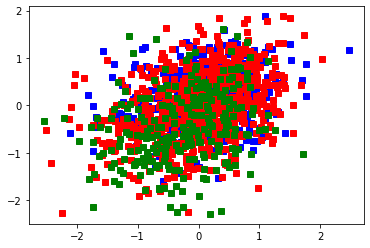

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
'''
for i in range(0,71):
  for j in range(0,71):
    if i==j: pass
    else:
      plt.plot((y_cls.values==1).T[0] * X[:,i],(y_cls.values==1).T[0] * X[:,j],"bs",label="class 1")
      plt.plot((y_cls.values==2).T[0] * X[:,i],(y_cls.values==2).T[0] * X[:,j],"rs",label="class 2")
      plt.plot((y_cls.values==3).T[0] * X[:,i],(y_cls.values==3).T[0] * X[:,j],"gs",label ="class 3")  
      plt.show()
'''
plt.plot((y_cls==1)* X[:,1],(y_cls==1)* X[:,2],"bs",label="class 1")
plt.plot((y_cls==2) * X[:,1],(y_cls==2) * X[:,2],"rs",label="class 2")
plt.plot((y_cls==3) * X[:,1],(y_cls==3) * X[:,2],"gs",label ="class 3")  
plt.show()


# test set(제출용)
---

In [0]:
# Load test dataset
csv_file_test = '/content/gdrive/My Drive/BNCS401_Midterm_Project/Test_data_ageupdated.csv'  # Set your path
test_data = pd.read_csv(csv_file_test)
test_data

,RID,AGE,ST102TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST103TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST104TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST105TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST106TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST107TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST108TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST109TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST110TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST111TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST113TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST114TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST115TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST116TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST117TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST118TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST119TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST121TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST123TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST129TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST130TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST13TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST14TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST15TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST23TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST24TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST25TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST26TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST31TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST32TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST34TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST35TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST36TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST38TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST39TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST40TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST43TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST44TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST45TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST46TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST47TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST48TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST49TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST50TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST51TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST52TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST54TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST55TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST56TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST57TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST58TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST59TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST60TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST62TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST64TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST72TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST73TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST74TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST82TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST83TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST84TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST85TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST90TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST91TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST93TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST94TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST95TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST97TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16
0,1002,76.3,1.996,2.220,2.342,2.803,2.230,1.402,1.764,2.156,2.026,1.941,2.964,2.122,2.454,1.925,2.451,2.311,3.016,2.317,1.121,2.956,2.936,2.219,2.907,2.320,1.573,3.061,2.696,2.529,2.283,2.949,2.293,2.097,2.686,1.768,2.387,2.674,1.819,2.135,2.133,3.003,2.374,1.411,1.727,2.434,2.157,2.063,3.182,2.085,2.485,1.905,2.488,2.182,3.563,2.187,0.975,2.338,2.253,2.476,1.639,3.655,2.507,2.461,2.157,2.911,2.410,1.968,2.800,1.767,2.080,2.766
1,260,78.6,2.209,2.805,2.386,2.710,2.209,1.517,1.648,2.457,2.184,2.132,3.077,2.279,2.552,2.169,2.338,2.342,4.067,2.303,1.082,3.035,2.973,2.370,2.669,2.502,1.914,3.925,2.438,2.820,2.380,2.932,2.328,2.134,2.831,1.838,2.635,2.786,2.219,2.797,2.456,2.797,2.147,1.469,1.729,2.692,2.329,2.274,2.994,2.268,2.627,2.142,2.458,2.314,3.839,2.167,1.228,2.366,2.834,2.320,1.607,3.849,2.843,2.619,2.484,2.811,2.402,1.950,2.685,1.795,2.332,2.965
2,1406,61.1,2.114,3.157,2.700,2.856,2.463,1.610,1.671,2.720,2.174,2.170,2.997,2.353,2.818,1.856,2

In [0]:
test_data = test_data.drop("RID",axis=1)

In [0]:
incomplete_rows = test_data[test_data.isnull().any(axis=1)]#.head()
incomplete_rows

,AGE,ST102TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST103TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST104TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST105TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST106TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST107TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST108TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST109TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST110TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST111TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST113TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST114TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST115TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST116TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST117TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST118TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST119TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST121TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST123TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST129TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST130TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST13TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST14TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST15TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST23TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST24TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST25TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST26TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST31TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST32TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST34TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST35TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST36TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST38TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST39TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST40TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST43TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST44TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST45TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST46TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST47TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST48TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST49TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST50TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST51TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST52TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST54TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST55TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST56TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST57TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST58TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST59TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST60TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST62TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST64TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST72TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST73TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST74TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST82TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST83TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST84TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST85TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST90TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST91TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST93TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST94TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST95TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST97TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16


In [0]:
def object_to_float(o): #o = train_data["~~"] 형태
  for i in range(343):
    if o[i] == ' ':
      o[i] = np.nan #nan으로 채움

In [0]:
object_to_float(test_data["ST64TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
object_to_float(test_data["ST123TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
X_ = data_pipeline.fit_transform(test_data)

In [0]:
X_.shape

(344, 71)

In [0]:
'''
reg_mmse_predictions = final_mmse_reg.predict(X_)
reg_ada_predictions = final_ada_reg.predict(X_)
'''
reg_predictions = final_reg.predict(X_)

In [0]:
prediction_reg = DataFrame({"MMSE":reg_predictions[:,0],
                            "ADA13":reg_predictions[:,1]})
'''
prediction_reg = DataFrame({"MMSE":reg_mmse_predictions,
                            "ADA13":reg_ada_predictions})
                            '''

'\nprediction_reg = DataFrame({"MMSE":reg_mmse_predictions,\n                            "ADA13":reg_ada_predictions})\n                            '

In [0]:
prediction_reg

,MMSE,ADA13
0,27.766236,13.256609
1,28.256737,11.822731
2,28.258680,12.356931
3,28.076554,13.567189
4,25.305433,23.449884
...,...,...
339,28.232073,13.908885
340,28.100366,13.892758
341,27.737613,11.930887
342,27.149634,18.648599


In [0]:
X_ = pd.concat([test_data, prediction_reg],axis=1)

X_clf = data_pipeline.fit_transform(X_)

clf_predictions = final_clf.predict(X_clf)

prediction_clf = DataFrame({"MMSE":reg_predictions[:,0],
                             "ADA13":reg_predictions[:,1],
                            "DXCHANGE":clf_predictions})

prediction = prediction_clf

In [0]:
prediction

,MMSE,ADA13,DXCHANGE
0,27.766236,13.256609,2
1,28.256737,11.822731,2
2,28.258680,12.356931,2
3,28.076554,13.567189,2
4,25.305433,23.449884,1
...,...,...,...
339,28.232073,13.908885,2
340,28.100366,13.892758,2
341,27.737613,11.930887,1
342,27.149634,18.648599,2


In [0]:
prediction.to_csv('/content/gdrive/My Drive/Colab Notebooks/prediction.csv',encoding='utf-8')